# Imports

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

# Load Data

In [43]:
# Training Data
X = pd.read_csv('X.csv')

# Features
ys = pd.read_csv('ys.csv')

df = pd.concat([ys, X], axis=1)

# Make day sequential ints
df['day'] = range(1, len(df)+1)

# Baseline

## Today for tomorrow

In [45]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic
0,0.315732,0.090209
1,1.000000,0.315732
2,0.941694,1.000000
3,0.983498,0.941694
4,0.234323,0.983498


In [46]:
X = df_test.sr_gap_heuristic
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.2746893329253976

## Moving Average

In [47]:
# Select columns
df_test = df[['y1', 'sr_gap_heuristic_rolling_mean_expanding']].copy()

# Remove rows with NA in either column
df_test.dropna(inplace=True)

print(df_test.shape)
df_test.head()

(83, 2)


,y1,sr_gap_heuristic_rolling_mean_expanding
0,0.315732,0.090209
1,1.000000,0.202970
2,0.941694,0.468647
3,0.983498,0.586909
4,0.234323,0.666227


In [48]:
X = df_test.sr_gap_heuristic_rolling_mean_expanding
y = df_test.y1

# RMSE
mse = mean_squared_error(y_true=y, y_pred=X)
rmse = np.sqrt(mse)
rmse

0.24410813866050463

# Model Comparison

In [49]:
# Specify the start date
start_date = '2023-01-28'

# Determine the number of days based on the length of the DataFrame
num_days = len(df)

# Generate the date range
dates = pd.date_range(start=start_date, periods=num_days, freq='D')

# Create new column
df['date'] = dates

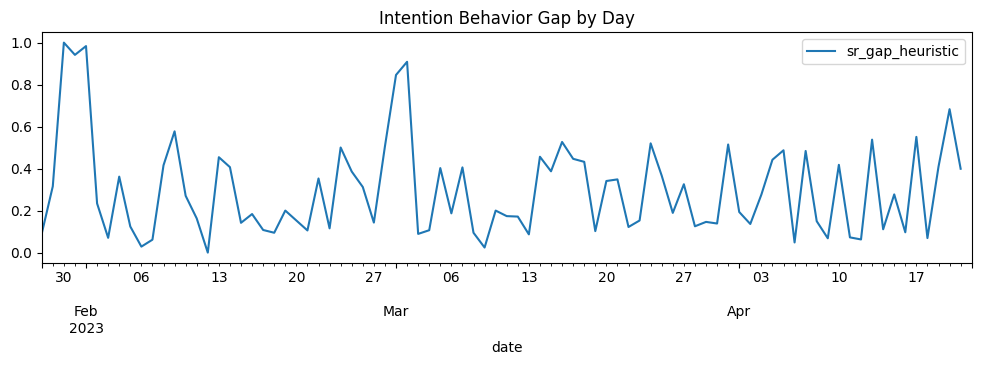

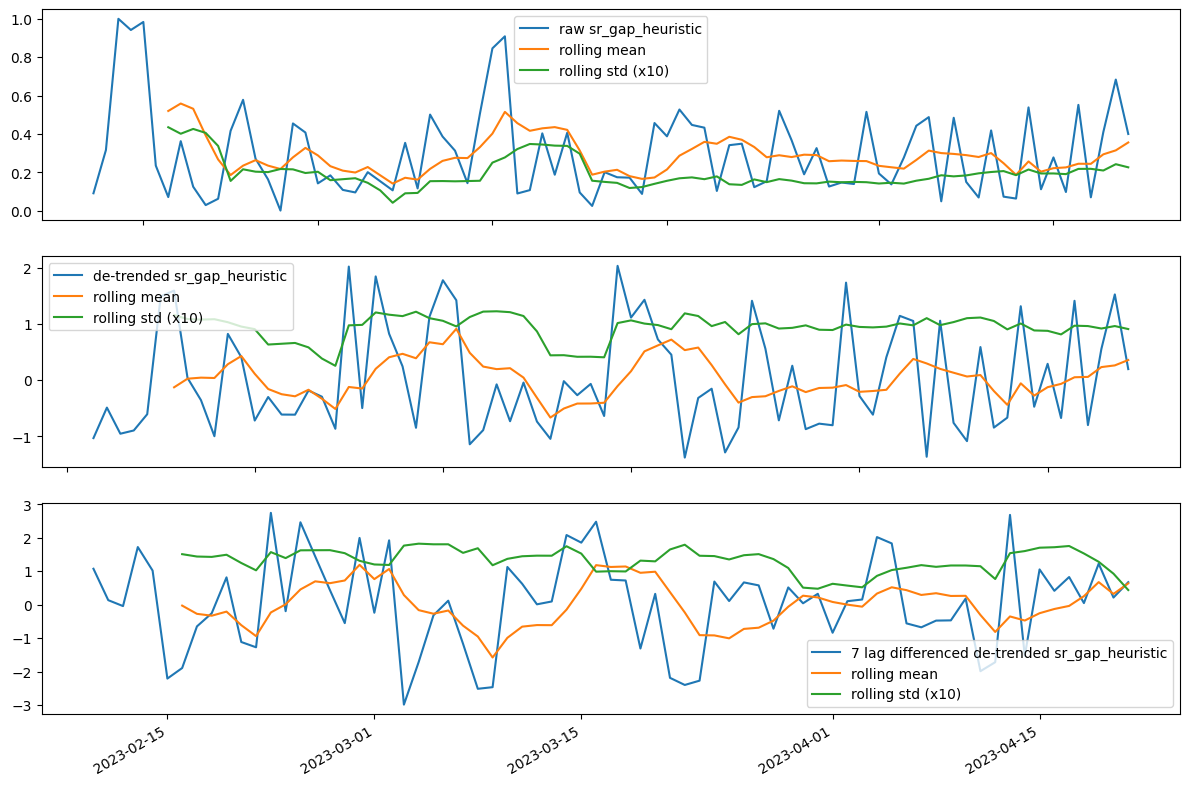

In [50]:
plt.style.use('default')
import matplotlib.dates as mdates

df_sub = pd.DataFrame(df, columns=['date','sr_gap_heuristic']).set_index('date')
df_sub = df_sub.asfreq('D') # Set the frequency to daily
train = df_sub.iloc[:-10, :]
test = df_sub.iloc[-10:, :]
pred = test.copy()
df_sub.plot(figsize=(12,3));
plt.title('Intention Behavior Gap by Day');

df_sub['z_sr_gap_heuristic'] = (df_sub['sr_gap_heuristic'] - df_sub.sr_gap_heuristic.rolling(window=7).mean()) / df_sub.sr_gap_heuristic.rolling(window=7).std()
df_sub['zp_sr_gap_heuristic'] = df_sub['z_sr_gap_heuristic'] - df_sub['z_sr_gap_heuristic'].shift(7)

def plot_rolling(df_sub):
    fig, ax = plt.subplots(3,figsize=(12, 9))
    ax[0].plot(df_sub.index, df_sub.sr_gap_heuristic, label='raw sr_gap_heuristic')
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[0].plot(df_sub.sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[0].legend()

    ax[1].plot(df_sub.index, df_sub.z_sr_gap_heuristic, label="de-trended sr_gap_heuristic")
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[1].plot(df_sub.z_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[1].legend()

    ax[2].plot(df_sub.index, df_sub.zp_sr_gap_heuristic, label="7 lag differenced de-trended sr_gap_heuristic")
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).mean(), label="rolling mean");
    ax[2].plot(df_sub.zp_sr_gap_heuristic.rolling(window=7).std(), label="rolling std (x10)");
    ax[2].legend()

    plt.tight_layout()
    fig.autofmt_xdate()

plot_rolling(df_sub)

## Traditional

### ARIMA/SARIMA

#### Stationarity

The cleaned time series passed the Augmented Dickey-Fuller (ADF) test, indicating that it is stationary. The test statistic 
−6.73 is well below the critical values, and the very small p-value (3.27×10−9) strongly rejects the null hypothesis of a unit root (non-stationarity).

Given that the data is stationary we can set the integrated term, `d` to 0.

In [51]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(df_sub.sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the de-trended data stationary ?")
dftest = adfuller(df_sub.z_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
print("\n > Is the 7-lag differenced de-trended data stationary ?")
dftest = adfuller(df_sub.zp_sr_gap_heuristic.dropna(), autolag='AIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))


 > Is the data stationary ?
Test statistic = -6.733
P-value = 0.000
Critical values :
	1%: -3.5117123057187376 - The data is  stationary with 99% confidence
	5%: -2.8970475206326833 - The data is  stationary with 95% confidence
	10%: -2.5857126912469153 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -8.169
P-value = 0.000
Critical values :
	1%: -3.518281134660583 - The data is  stationary with 99% confidence
	5%: -2.899878185191432 - The data is  stationary with 95% confidence
	10%: -2.5872229937594873 - The data is  stationary with 90% confidence

 > Is the 7-lag differenced de-trended data stationary ?
Test statistic = -4.556
P-value = 0.000
Critical values :
	1%: -3.548493559596539 - The data is  stationary with 99% confidence
	5%: -2.912836594776334 - The data is  stationary with 95% confidence
	10%: -2.594129155766944 - The data is  stationary with 90% confidence


                               SARIMAX Results                                
Dep. Variable:       sr_gap_heuristic   No. Observations:                   84
Model:                          ARIMA   Log Likelihood                   4.483
Date:                Wed, 01 May 2024   AIC                             -4.966
Time:                        12:39:08   BIC                             -0.104
Sample:                    01-28-2023   HQIC                            -3.012
                         - 04-21-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2990      0.033      8.930      0.000       0.233       0.365
sigma2         0.0526      0.009      6.137      0.000       0.036       0.069
Ljung-Box (L1) (Q):                   7.10   Jarque-

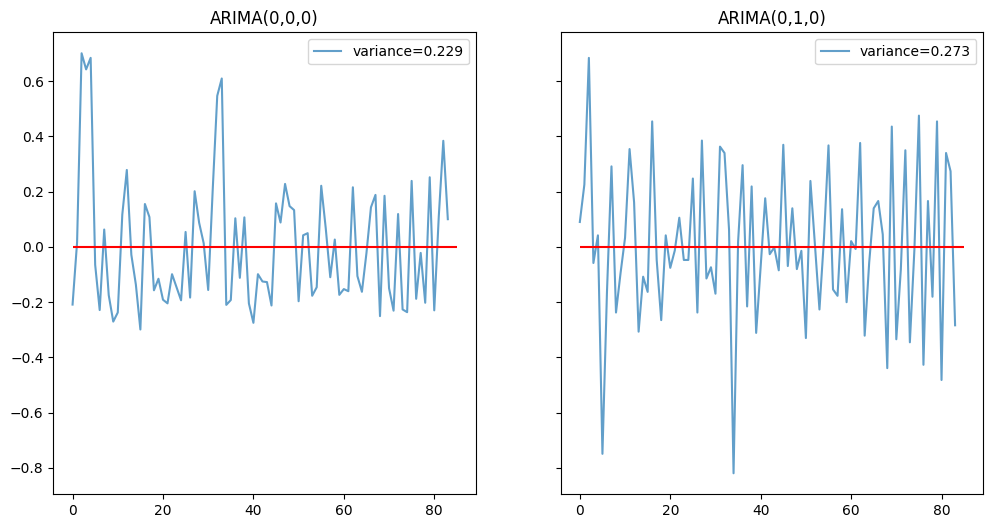

In [52]:
# Alt method for showing stationarity

from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 0, 0))
res_000 = model.fit()
print(res_000.summary())

model = ARIMA(df_sub.sr_gap_heuristic.dropna(), order=(0, 1, 0))
res_010 = model.fit()
print(res_010.summary())

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12, 6))
ax[0].plot(res_000.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_000.resid.values)));
ax[0].hlines(0, xmin=0, xmax=85, color='r');
ax[0].set_title("ARIMA(0,0,0)");
ax[0].legend();
ax[1].plot(res_010.resid.values, alpha=0.7, label='variance={:.3f}'.format(np.std(res_010.resid.values)));
ax[1].hlines(0, xmin=0, xmax=85, color='r');
ax[1].set_title("ARIMA(0,1,0)");
ax[1].legend();

#### Autocorrelation

Given the `PACF` function does not have any significant correlations we can set this value (`p`) to zero


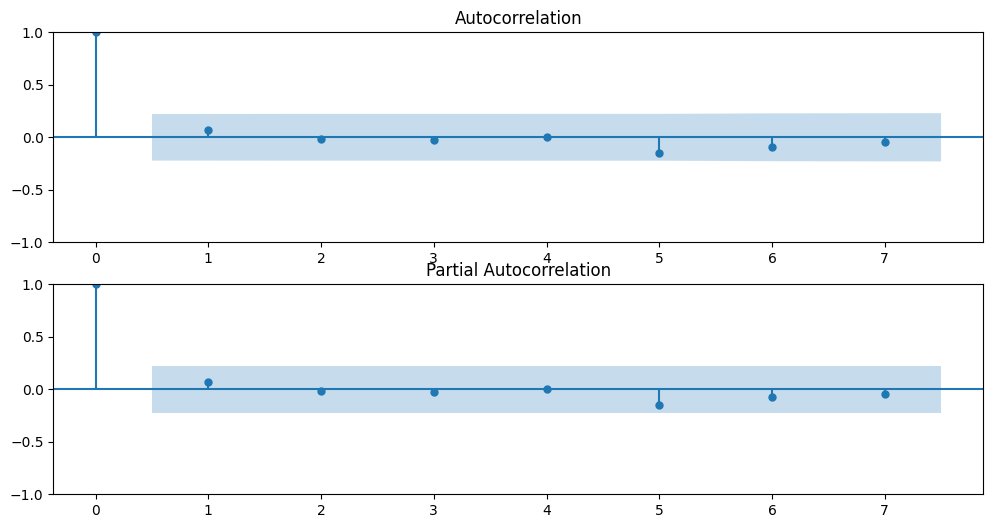

In [53]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[0], lags=7)
ax[1] = plot_pacf(df_sub.z_sr_gap_heuristic.dropna(), ax=ax[1], lags=7)

#### Predictive Model

The notation ARIMA(p, d, q) represents a specific configuration of the ARIMA model, which stands for AutoRegressive Integrated Moving Average. Let’s break down what each of these parameters represents in the context of ARIMA(1,0,1):

1. **p (AR part) - Autoregressive Term:**
- p = 1: This indicates that the model includes one lag of the series in the prediction. In other words, the model uses the first previous value to predict the current value. This part of the model captures the relationship between a given value and its predecessors.
2. **d (I part) - Integrated Term:**
- d = 0: This specifies the degree of differencing involved. Since d is 0, it means no differencing is needed, suggesting that the time series is already stationary. Differencing is a method of transforming a time series dataset to make it stationary, which is often necessary for ARIMA modeling as it relies on the assumption of stationarity.
3. **q (MA part) - Moving Average Term:**
- q = 1: This indicates that the model uses one moving average term. This part involves the error term of the model’s lagged forecasts. Essentially, it allows the model to account for the relationship between an observation and a residual error from a moving average model applied to lagged observations.

In [54]:
from statsmodels.tsa.arima.model import ARIMA # this accounts for NaNs

p = 0 # autoregressive term
d = 0 # integrated term
q = 0 # moving avearge term

# Split the data into train and test sets for ARIMA model fitting and forecasting
train_size_cleaned = int(len(df) * 0.8)
train_cleaned, test_cleaned = df['sr_gap_heuristic'][:train_size_cleaned], df['sr_gap_heuristic'][train_size_cleaned:]

# Fit the ARIMA model (using ARIMA(X,0,1) as an example configuration)
model_cleaned = ARIMA(train_cleaned, order=(p, d, q))
fitted_model_cleaned = model_cleaned.fit()

# Forecast on the test data
forecast_cleaned = fitted_model_cleaned.forecast(steps=len(test_cleaned))

# Calculate RMSE
mask = ~np.isnan(test_cleaned) & ~np.isnan(forecast_cleaned) # remove NaN values
rmse_cleaned = np.sqrt(mean_squared_error(test_cleaned[mask], forecast_cleaned[mask]))
rmse_cleaned, forecast_cleaned.head()

(0.21179911705509147,
 68    0.304124
 69    0.304124
 70    0.304124
 71    0.304124
 72    0.304124
 Name: predicted_mean, dtype: float64)

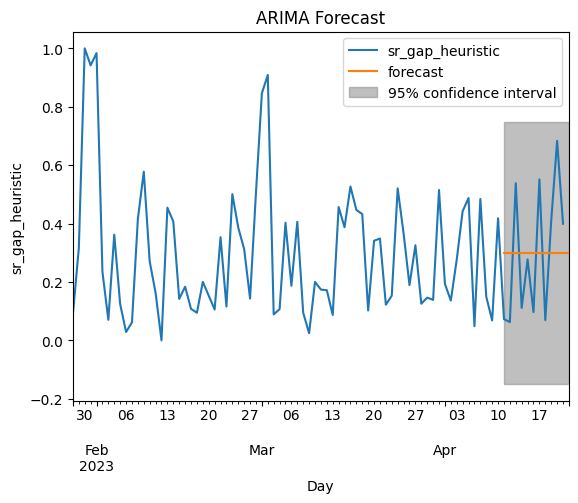

In [56]:
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

res = ARIMA(df_sub['sr_gap_heuristic'], order=(0,0,0)).fit()

fig, ax = plt.subplots()
ax = df_sub['sr_gap_heuristic'].plot(ax=ax)
plot_predict(res, '2023-04-11', '2023-04-22', ax=ax)
plt.title('ARIMA Forecast')
plt.xlabel('Day')
plt.ylabel('sr_gap_heuristic')
plt.show()

### Exponential Smoothing

The RMSE of the model is: 0.2448171326616217


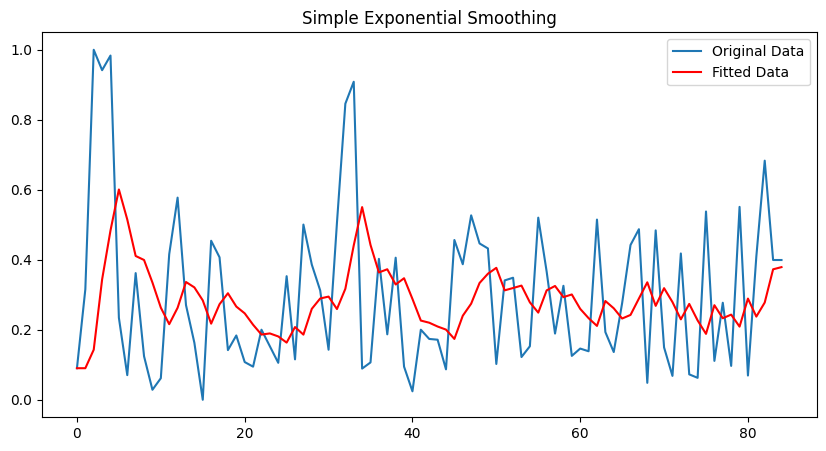

In [57]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

series = df['sr_gap_heuristic']  # replace 'your_time_series_column' with the name of your column

# Optionally, handle missing values if necessary
series.fillna(method='ffill', inplace=True)  # forward fill to handle NaNs

# Initialize the model
model = SimpleExpSmoothing(series)

# Fit the model
fitted_model = model.fit(optimized=True)  # Let the model optimize the smoothing level

# Predict on the in-sample data
predictions = fitted_model.fittedvalues

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(series, predictions))
print("The RMSE of the model is:", rmse)

plt.figure(figsize=(10, 5))
plt.plot(series, label='Original Data')
plt.plot(predictions, label='Fitted Data', color='red')
plt.title('Simple Exponential Smoothing')
plt.legend()
plt.show()

## Machine Learning

### Gradient Boosting

In [58]:
# need to drop tailing rows since no y1 value
df.y1.tail()

80    0.409241
81    0.683168
82    0.399340
83         NaN
84         NaN
Name: y1, dtype: float64

In [64]:
df_copy = df.copy()
df_copy = df_copy.iloc[:-2]

In [68]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Prepare features and target
X = df_copy.drop(['y1', 'y2', 'y3', 'date'], axis=1)  # exclude the future values of gap
y = df_copy['y1'] # 1 day in future

# Splitting the data (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

# Initialize the model
model = HistGradientBoostingRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Using cross-validation to evaluate the model
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(rmse_scores)
print("Cross-validated RMSE: ", np.mean(rmse_scores))

[0.41969293 0.2201704  0.27078455 0.27499121 0.16837421]
Cross-validated RMSE:  0.27080266049335633


In [69]:
# Predicting on test set
y_pred = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE: ", test_rmse)

Test RMSE:  0.21823006940631903


#### Prediction

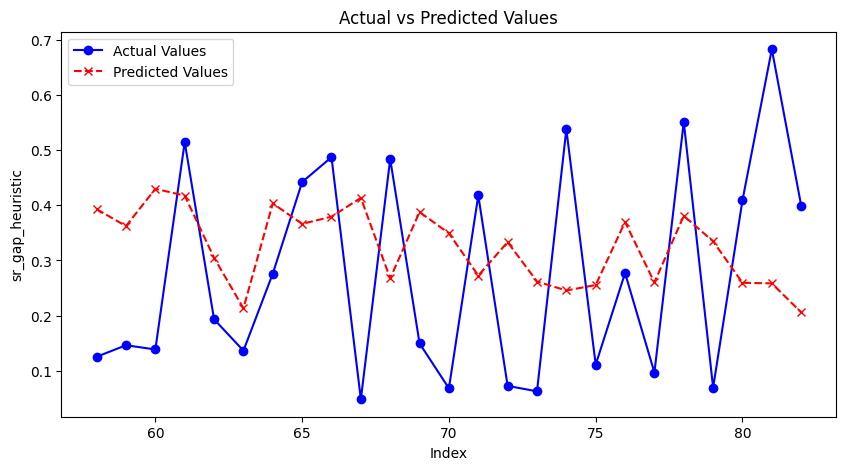

In [70]:
# Create a DataFrame from y_test for easy plotting
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=y_test.index)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Actual Values', color='blue', marker='o')
plt.plot(test_results['Predicted'], label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('sr_gap_heuristic')
plt.legend()
plt.show()

#### Feature Importance

In [71]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Store the importances in a DataFrame for easier plotting
importance_df = pd.DataFrame({'features': X.columns, 'importance_mean': result.importances_mean})
importance_df.sort_values(by='importance_mean', ascending=False, inplace=True)

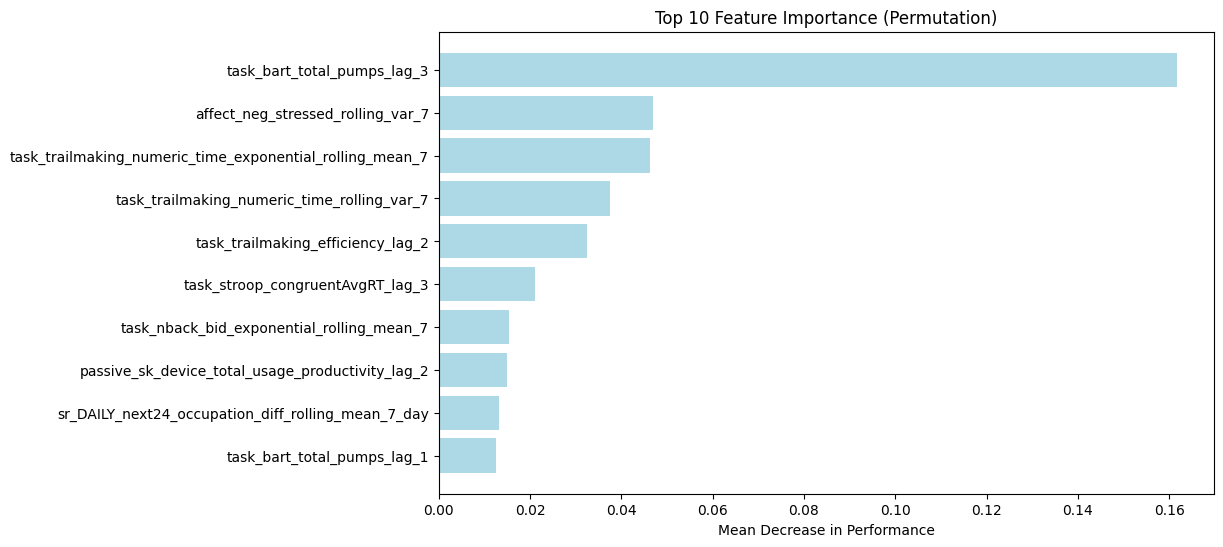

In [72]:
# Selecting the top 10 most important features
top_10_features = importance_df.head(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['features'], top_10_features['importance_mean'], color='lightblue')
plt.xlabel('Mean Decrease in Performance')
plt.title('Top 10 Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

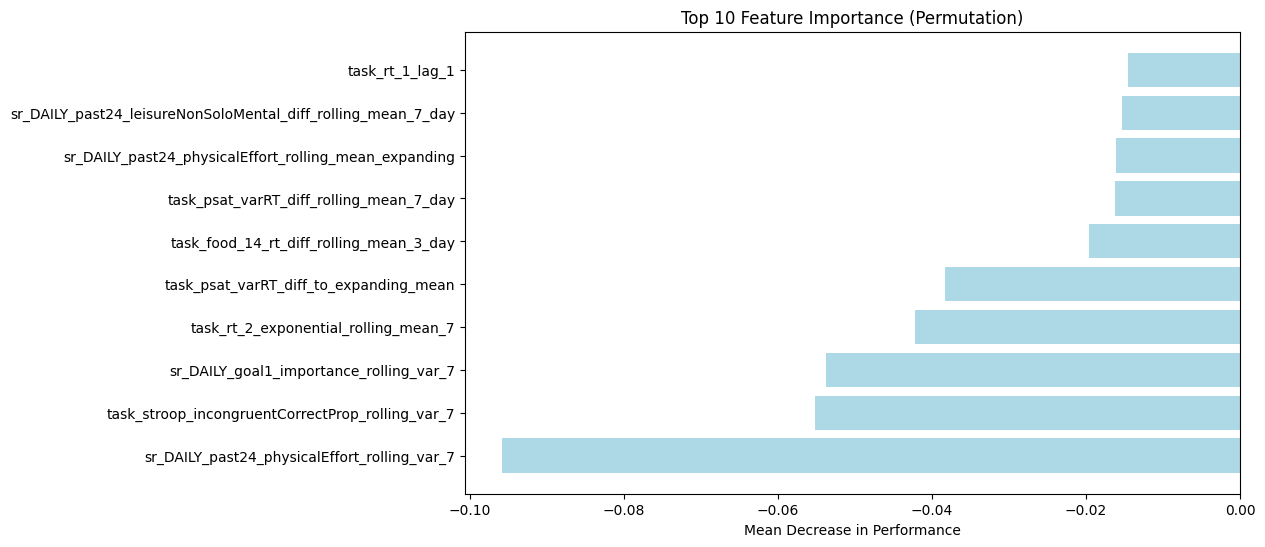

In [247]:
# Selecting the top 10 most important features
top_10_features = importance_df.tail(10)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['features'], top_10_features['importance_mean'], color='lightblue')
plt.xlabel('Mean Decrease in Performance')
plt.title('Top 10 Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

### SVM

In [86]:
print(df_copy.shape)

# Calculate the percentage of NaNs in each column
nan_percentage = df_copy.isna().mean()

# Filter out columns with more than 50% NaN values
df_copy_filtered = df_copy.loc[:, nan_percentage <= 0.5]

df_copy_filtered.shape

(83, 3323)


(83, 3288)

In [75]:
y.shape

(83,)

In [87]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV



# Prepare features and target
X = df_copy_filtered.drop(['y1', 'y2', 'y3', 'date'], axis=1)  # exclude the future values of gap
y = df_copy_filtered['y1'] # 1 day in future

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change 'mean' to 'median' or 'most_frequent' if needed
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='linear'))  # Starting with a linear kernel
])

param_grid = {
    'imputer__strategy': ['mean', 'median'],  # Exploring different imputation strategies    
    'svr__kernel': ['linear', 'rbf'],  # Include different kernels to test
    'svr__C': [0.01, 0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 0.5, 1],
    'svr__gamma': ['scale', 'auto']  # For RBF kernel
}

# Grid search to find the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(-grid_search.best_score_))

Best parameters: {'imputer__strategy': 'mean', 'svr__C': 0.01, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Best cross-validation score: 0.04


In [88]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate RMSE for the test set predictions
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)

Test RMSE: 0.258757818965196


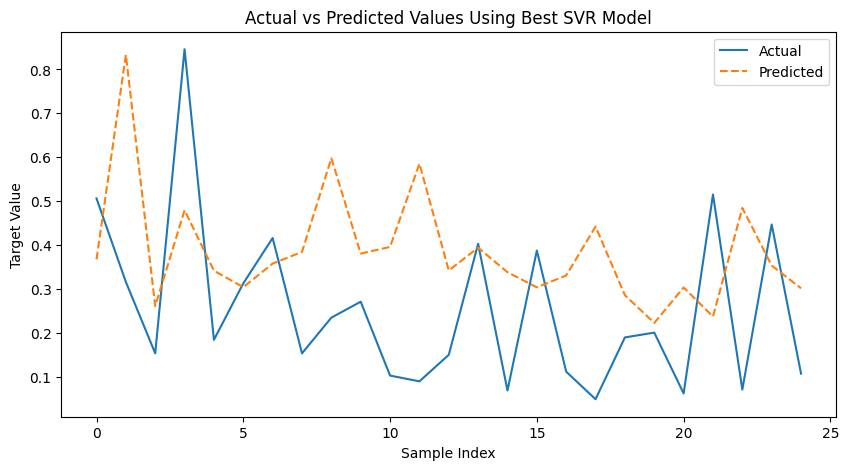

In [89]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.reset_index(drop=True), label='Actual')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Actual vs Predicted Values Using Best SVR Model')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()